In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.wkt import loads
import pickle

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, BoundaryNorm

from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
path ='/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Python Workspace/IIT Courses/TIF DS Project/Final/data/'

with open(path + 'new_df.pickle', 'rb') as file:
    df = pickle.load(file)

JJ_path = '/content/drive/MyDrive/IPRO497_Demographic Team/Final/data/'
K_path = '/Users/kunwoosmac/Library/Mobile Documents/com~apple~CloudDocs/Python Workspace/IIT Courses/TIF DS Project/Final/data/'

path = K_path

# Standardize
x = df.copy()
features = x.columns
x = StandardScaler().fit_transform(x)
df = pd.DataFrame(x, columns=features)

# Decided to use KMeans of k = 4

In [3]:
k = 4
clusterer = KMeans(n_clusters = k, random_state = 0, n_init = "auto").fit(df)
silhouette_avg = silhouette_score(df, clusterer.labels_)
print(f'cluster number : {k} - silhouette index {silhouette_avg}') # <- this is the best output

print(dict(sorted(dict(Counter(clusterer.labels_)).items())))


cluster number : 4 - silhouette index 0.401269220899922
{0: 13, 1: 11, 2: 39, 3: 14}


In [4]:
censusBlock = gpd.read_file(path + 'Boundaries - Census Blocks.geojson')
Community_area = gpd.read_file(path + 'Boundaries - Community Areas (current).geojson')

Blockgroup_boundary = pd.read_csv(path+'cleanBlockGroups.csv')
Blockgroup_boundary = Blockgroup_boundary.drop(columns=['coords'])

Blockgroup_race = pd.read_csv(path + 'Blockgroup_race_2010.csv', header=0)
# Blockgroup_race_2020 = pd.read_csv(path + 'Blockgroup_race_2020.csv', header=0)
Blockgroup_race = gpd.GeoDataFrame(Blockgroup_race)

# Load Racial Population Data

In [5]:
with open(path + 'year_race_community_population_Non_TIF.pickle', 'rb') as file:
    non_TIF_community_pop = pickle.load(file)

with open(path + 'year_race_community_population_TIF.pickle', 'rb') as file:
    TIF_community_pop = pickle.load(file)

In [6]:
non_TIF_community_pop

,Community,White Population,Black Population,Hispanic Population
0,DOUGLAS,"[1066.3169148766137, 1066.3169148766137, 1066....","[7447.096142150383, 7447.096142150383, 7447.09...","[248.923996438452, 248.923996438452, 248.92399..."
1,OAKLAND,"[117.6633454009905, 117.6633454009905, 117.663...","[3717.700309610461, 3717.7003096104618, 3717.7...","[51.3855573115803, 51.385557311580314, 51.3855..."
2,FULLER PARK,"[14.477193433160375, 14.477193433160375, 14.47...","[608.2486881226725, 608.2486881226725, 608.248...","[27.111599649068218, 27.111599649068225, 27.11..."
3,GRAND BOULEVARD,"[99.48174033198991, 99.48174033198991, 99.4817...","[2906.3042777167766, 2906.304277716777, 2906.3...","[58.57221209235427, 58.57221209235427, 58.5722..."
4,KENWOOD,"[3074.4412074235347, 3074.4412074235347, 3074....","[11632.800999534104, 11632.800999534104, 11632...","[515.293553191483, 515.293553191483, 515.29355..."
...,...,...,...,...
72,MOUNT GREENWOOD,"[15672.05158804668, 15672.05158804668, 15672.0...","[942.2428266816345, 942.2428266816345, 942.242...","[1307.9048297024333, 1307.9048297024333, 1307...."
73,MORGAN PARK,"[4807.723319529849, 4807.723319529849, 4807.72...","[3692.471063012119, 3692.471063012119, 3692.47...","[348.7812695366565, 348.7812695366565, 348.781..."
74,OHARE,"[15806.0, 15806.0, 15806.0, 15806.0, 15806.0, ...","[574.0, 574.0, 574.0, 574.0, 574.0, 574.0]","[4270.0, 4270.0, 4270.0, 4270.0, 4270.0, 4270.0]"
75,EDGEWATER,"[25089.813696231813, 5181.528159255175, 5181.5...","[5994.322140992251, 982.2768357999446, 982.276...","[6730.745133801631, 2369.7860041554814, 2369.7..."


In [7]:
white = np.array(list(non_TIF_community_pop['White Population']))[:,-1] + np.array(list(TIF_community_pop['White Population']))[:,-1]
black = np.array(list(non_TIF_community_pop['Black Population']))[:,-1] + np.array(list(TIF_community_pop['Black Population']))[:,-1]
latino = np.array(list(non_TIF_community_pop['Hispanic Population']))[:,-1] + np.array(list(TIF_community_pop['Hispanic Population']))[:,-1]

In [8]:
community_pop = pd.DataFrame()

community_pop['Community'] = non_TIF_community_pop['Community']
community_pop['Cluster'] = np.array(clusterer.labels_)

community_pop['White Percentage'] = white/(white+black+latino)
community_pop['Black Percentage'] = black/(white+black+latino)
community_pop['Latino Percentage'] = latino/(white+black+latino)

In [9]:
community_pop

,Community,Cluster,White Percentage,Black Percentage,Latino Percentage
0,DOUGLAS,2,0.125217,0.845364,0.029419
1,OAKLAND,2,0.027611,0.957440,0.014949
2,FULLER PARK,2,0.018489,0.935455,0.046056
3,GRAND BOULEVARD,2,0.024393,0.957461,0.018146
4,KENWOOD,2,0.192038,0.775485,0.032477
...,...,...,...,...,...
72,MOUNT GREENWOOD,2,0.874390,0.052520,0.073090
73,MORGAN PARK,2,0.303847,0.667117,0.029035
74,OHARE,2,0.518620,0.348659,0.132721
75,EDGEWATER,0,0.644231,0.167379,0.188390


# Load Median Income Data

In [10]:
with open(path+'year_race_community_Median_TIF.pickle', 'rb') as f:
	year_race_community_Median_TIF = pickle.load(f)
with open(path+'year_race_community_Median_Non_TIF.pickle', 'rb') as f:
	year_race_community_Median_Non_TIF = pickle.load(f)

In [11]:
year_race_community_Median_TIF

,Community,Median Income of White,Median Income of Black,Median Income of Latin
0,DOUGLAS,"[35594.07596137296, 34469.69396548094, 36479.5...","[27290.326154931103, 27864.88892125089, 26992....","[35203.0806568707, 34213.02245260347, 34697.29..."
1,OAKLAND,"[33186.21315668916, 34860.50847548244, 36118.7...","[26736.779974065204, 26937.633662090157, 32818...","[28499.522385826007, 29310.338514955423, 33782..."
2,FULLER PARK,"[25970.695420553457, 26903.502067331432, 28251...","[22221.476442319527, 22102.050979857457, 21869...","[28877.699254278035, 26097.94873133565, 24741...."
3,GRAND BOULEVARD,"[34376.19162748741, 36282.96121871879, 37922.4...","[29452.103070306945, 30450.841919979892, 32109...","[28720.641957655796, 29851.192004804445, 29848..."
4,KENWOOD,"[39449.01297747469, 43312.53045997965, 43772.4...","[23631.28980860365, 26127.758153582166, 26052....","[37584.82865234997, 40815.20917822987, 41962.4..."
...,...,...,...,...
72,MOUNT GREENWOOD,"[95073.62731170874, 93078.2291142332, 93308.69...","[85848.79044344602, 85833.43602746433, 82055.3...","[94733.58634081873, 91928.23125981407, 92076.9..."
73,MORGAN PARK,"[67303.70284195863, 64975.431727627576, 71007....","[40494.343333680605, 42163.115432499355, 46129...","[52862.84780539563, 52236.34508399746, 57196.8..."
74,OHARE,"[67303.70284195863, 64975.431727627576, 71007....","[40494.343333680605, 42163.115432499355, 46129...","[52862.84780539563, 52236.34508399746, 57196.8..."
75,EDGEWATER,"[39243.16344125476, 53100.62080218478, 55549.4...","[34620.02837150011, 43346.945645893786, 45233....","[41138.34404377405, 51419.97984957575, 54842.8..."


In [12]:
white = np.array(list(year_race_community_Median_Non_TIF['Median Income of White']))[:,-1] + np.array(list(year_race_community_Median_TIF['Median Income of White']))[:,-1]
black = np.array(list(year_race_community_Median_Non_TIF['Median Income of Black']))[:,-1] + np.array(list(year_race_community_Median_TIF['Median Income of Black']))[:,-1]
latino = np.array(list(year_race_community_Median_Non_TIF['Median Income of Latin']))[:,-1] + np.array(list(year_race_community_Median_TIF['Median Income of Latin']))[:,-1]

In [13]:
# community_pop['White Median Income'] = white
# community_pop['Black Median Income'] = black
# community_pop['Latino Median Income'] = latino

community_pop['Median Income'] = (white + black + latino)/3

In [14]:
community_pop

,Community,Cluster,White Percentage,Black Percentage,Latino Percentage,Median Income
0,DOUGLAS,2,0.125217,0.845364,0.029419,94464.862287
1,OAKLAND,2,0.027611,0.957440,0.014949,58796.167546
2,FULLER PARK,2,0.018489,0.935455,0.046056,35112.341207
3,GRAND BOULEVARD,2,0.024393,0.957461,0.018146,84086.379533
4,KENWOOD,2,0.192038,0.775485,0.032477,109704.236780
...,...,...,...,...,...,...
72,MOUNT GREENWOOD,2,0.874390,0.052520,0.073090,191947.112118
73,MORGAN PARK,2,0.303847,0.667117,0.029035,143351.990627
74,OHARE,2,0.518620,0.348659,0.132721,132393.184533
75,EDGEWATER,0,0.644231,0.167379,0.188390,141359.955945


# Plot Per Cluster

In [15]:
cluster_demo = []

for cluster_number in range(5):
    cluster_idx = np.where(np.array(community_pop['Cluster']) == cluster_number)[0]
    cluster_pop = community_pop.iloc[cluster_idx]
    cluster_demo.append(cluster_pop)

# Box Plots for Population Percentage

In [21]:
cluster_demo[0].iloc[:, 2:5]

,White Percentage,Black Percentage,Latino Percentage
5,0.738201,0.044219,0.217581
14,0.576696,0.014630,0.408673
16,0.743492,0.007932,0.248576
19,0.583078,0.149064,0.267858
24,0.613219,0.082807,0.303974
30,0.606750,0.231184,0.162066
35,0.860082,0.017172,0.122746
36,0.822019,0.122678,0.055302
44,0.875647,0.042743,0.081609
47,0.831680,0.025126,0.143193


In [97]:
import matplotlib as mpl
actual_cmap = mpl.colormaps['GnBu']
cluster_colors = actual_cmap(np.linspace(0,1,4))

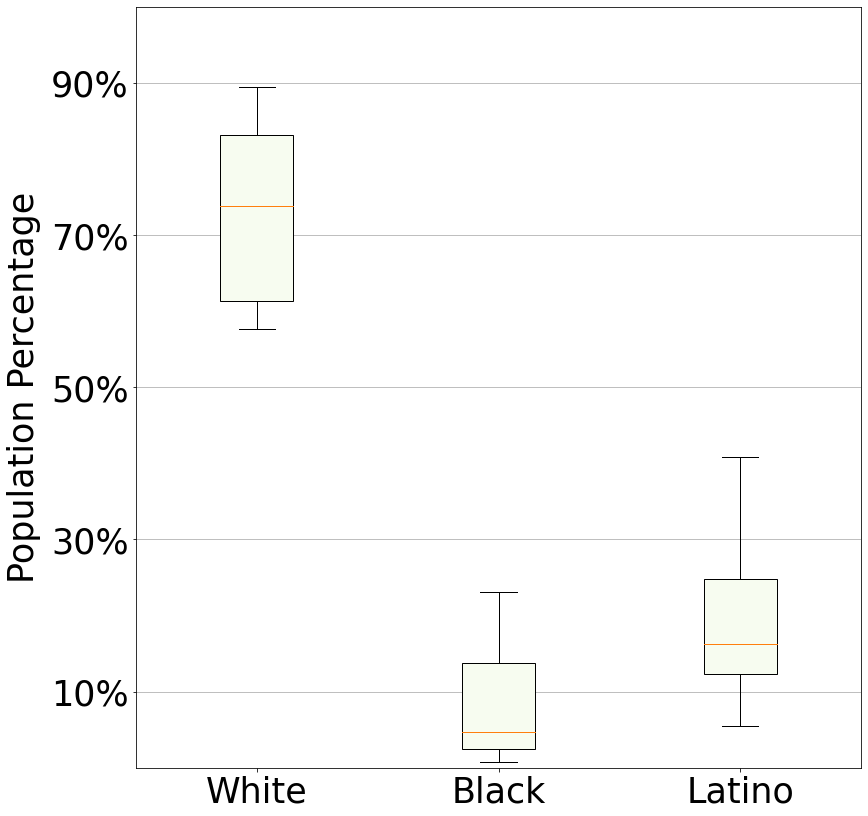

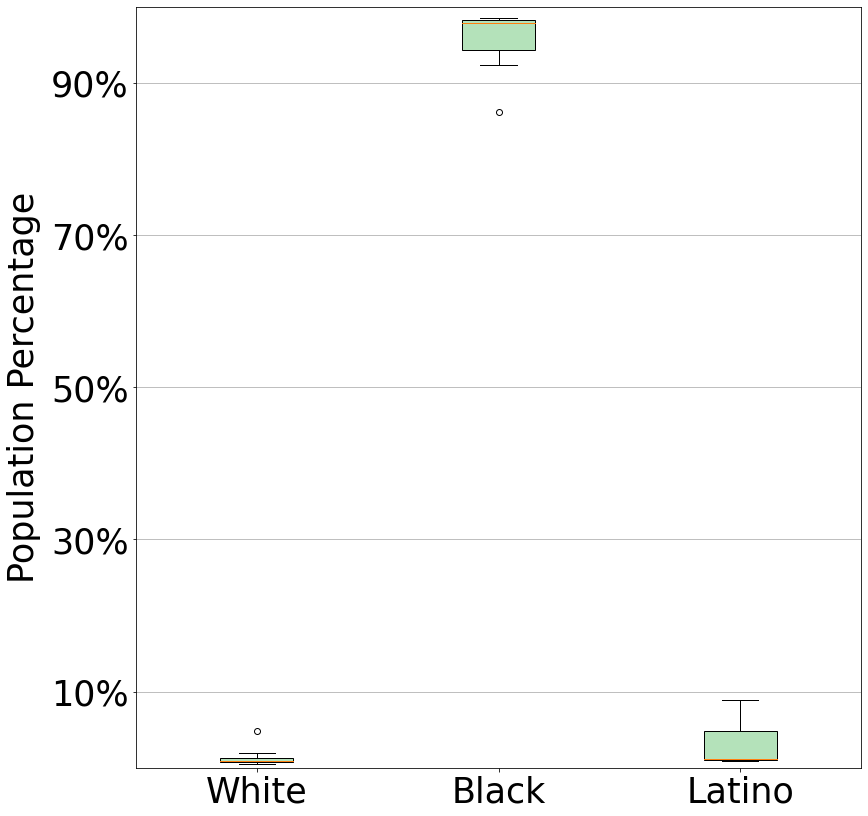

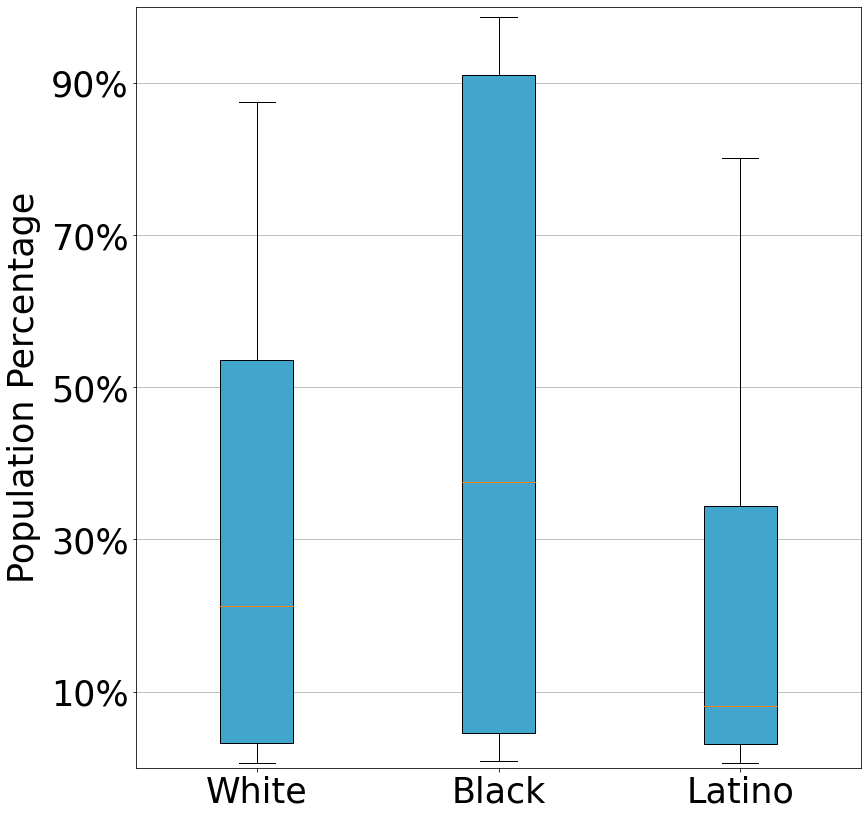

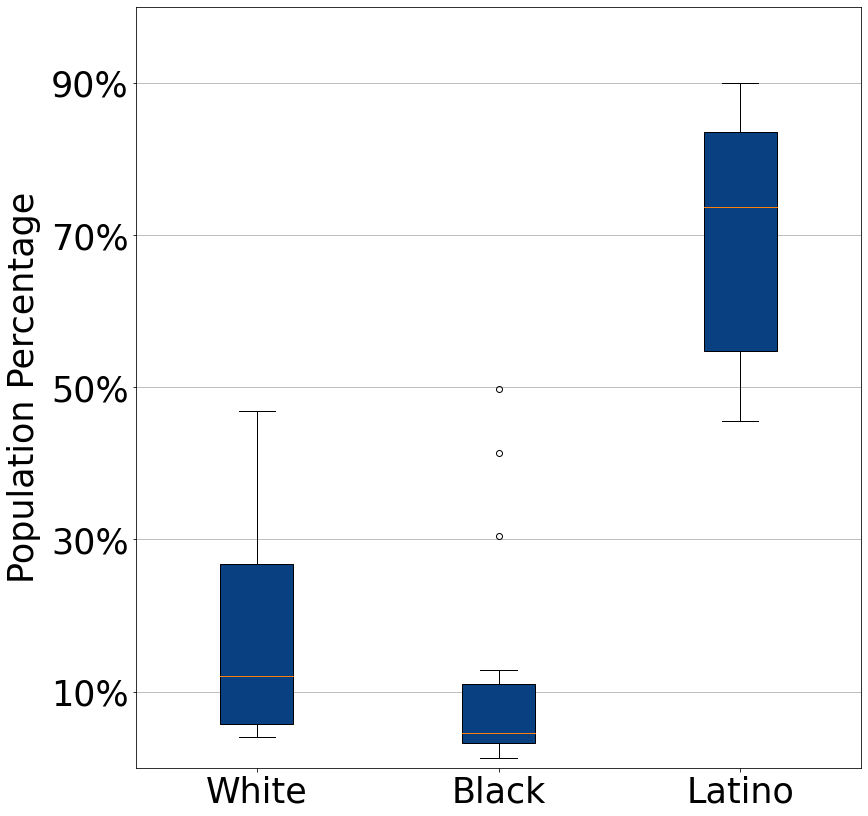

In [101]:
cluster_num = 0
# fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30, 20))

for cluster_num in range(4):
    labels = list(cluster_demo[cluster_num].columns)[2:5]
    demographics = cluster_demo[cluster_num].iloc[:,2:5]
    plt.figure(figsize = (13, 14))

    # rectangular box plot
    bplot1 = plt.boxplot(demographics,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=['White', 'Black', 'Latino'])  # will be used to label x-ticks
    # plt.title(f'Population Percentage of Cluster {cluster_num + 1}')

    plt.ylim(0,1)
    plt.ylabel('Population Percentage', fontsize = 35, labelpad = 10)
    plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9], ['10%', '30%', '50%', '70%', '90%'], fontsize = 35)
    # plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9], [' ', ' ', ' ', ' ', ' '], fontsize = 35)

    plt.xticks(fontsize = 35)
    # fill with colors
    colors = [cluster_colors[cluster_num]]*3
    for bplot in (bplot1):
        for patch, color in zip(bplot1['boxes'], colors):
            patch.set_facecolor(color)

    plt.grid(axis = 'y')
    plt.show()


# Median Income Plot

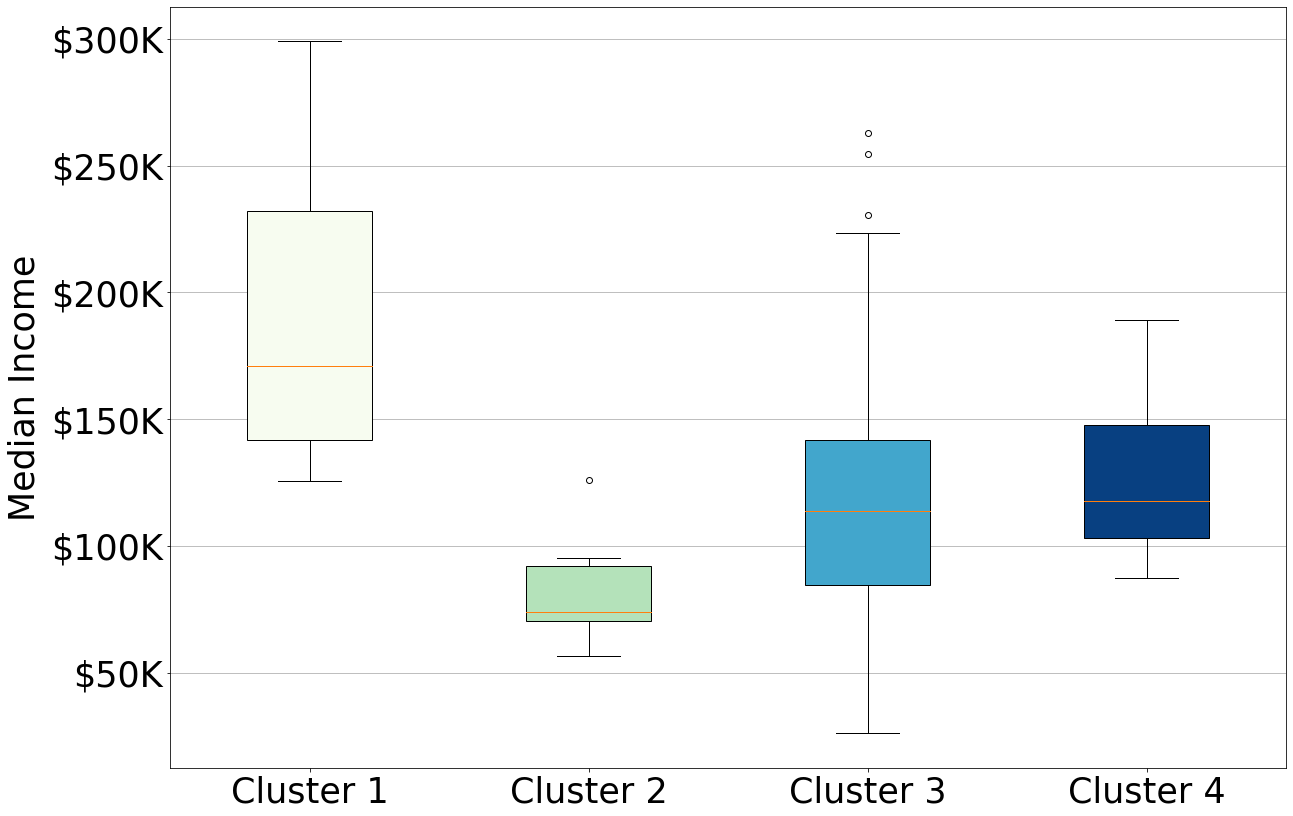

In [105]:
# labels = np.full(4, 'Cluster ') + np.array([1,2,3,4])

plt.figure(figsize=(20,14))

median_income_dict = {}
labels = []

for cluster_num in range(4):
    cluster_median_income = cluster_demo[cluster_num]['Median Income']
    name = 'Cluster ' + str(cluster_num + 1)
    labels.append(name)
    median_income_dict[name] = np.array(cluster_median_income)

median_income_dict
# median_incomes = cluster_demo[cluster_num].iloc[:,5:]
# plt.figure(figsize = (8, 8))

# rectangular box plot
bplot1 = plt.boxplot(list(median_income_dict.values()),
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=labels)  # will be used to label x-ticks

# fill with colors
colors = cluster_colors
for bplot in (bplot1):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

# plt.ylim(0,1)
plt.yticks([50000, 100000, 150000, 200000, 250000, 300000], ['$50K', '$100K','$150K','$200K','$250K','$300K'], fontsize = 35)
plt.xticks(fontsize = 35)
plt.ylabel('Median Income', fontsize = 35, labelpad=10)

plt.grid(axis = 'y')
plt.show()


# Median Income Increase Plot

In [106]:
with open(path+'year_race_community_Median_TIF.pickle', 'rb') as f:
	year_race_community_Median_TIF = pickle.load(f)
with open(path+'year_race_community_Median_Non_TIF.pickle', 'rb') as f:
	year_race_community_Median_Non_TIF = pickle.load(f)

In [118]:
k = 4
clusterer = KMeans(n_clusters = k, random_state = 0, n_init = "auto").fit(df)

In [119]:
def percent_median_income_increase(year_race_community_Median_info):
  total = np.zeros((3,4))
  for race_num, race_name in enumerate(['Median Income of White','Median Income of Black','Median Income of Latin']):
    up_left = np.zeros(4)
    up_right = np.zeros(4)
    down = np.zeros(4)
    num = np.zeros(4)


    for com_num, cluster_name in enumerate(np.array(clusterer.labels_)):
      up_left[cluster_name] += year_race_community_Median_info[race_name].iloc[com_num][0]
      up_right[cluster_name] += year_race_community_Median_info[race_name].iloc[com_num][-1]
      down[cluster_name] += year_race_community_Median_info[race_name].iloc[com_num][0]
      num[cluster_name] +=1

    total[race_num] = (up_right - up_left)*100/down
  total = total.T
  # print(total)
  df = pd.DataFrame(total, columns=['White','Black','Latino'])
  return df

In [120]:
Median_income_increase_TIF = percent_median_income_increase(year_race_community_Median_TIF)
Median_income_increase_Non_TIF = percent_median_income_increase(year_race_community_Median_Non_TIF)

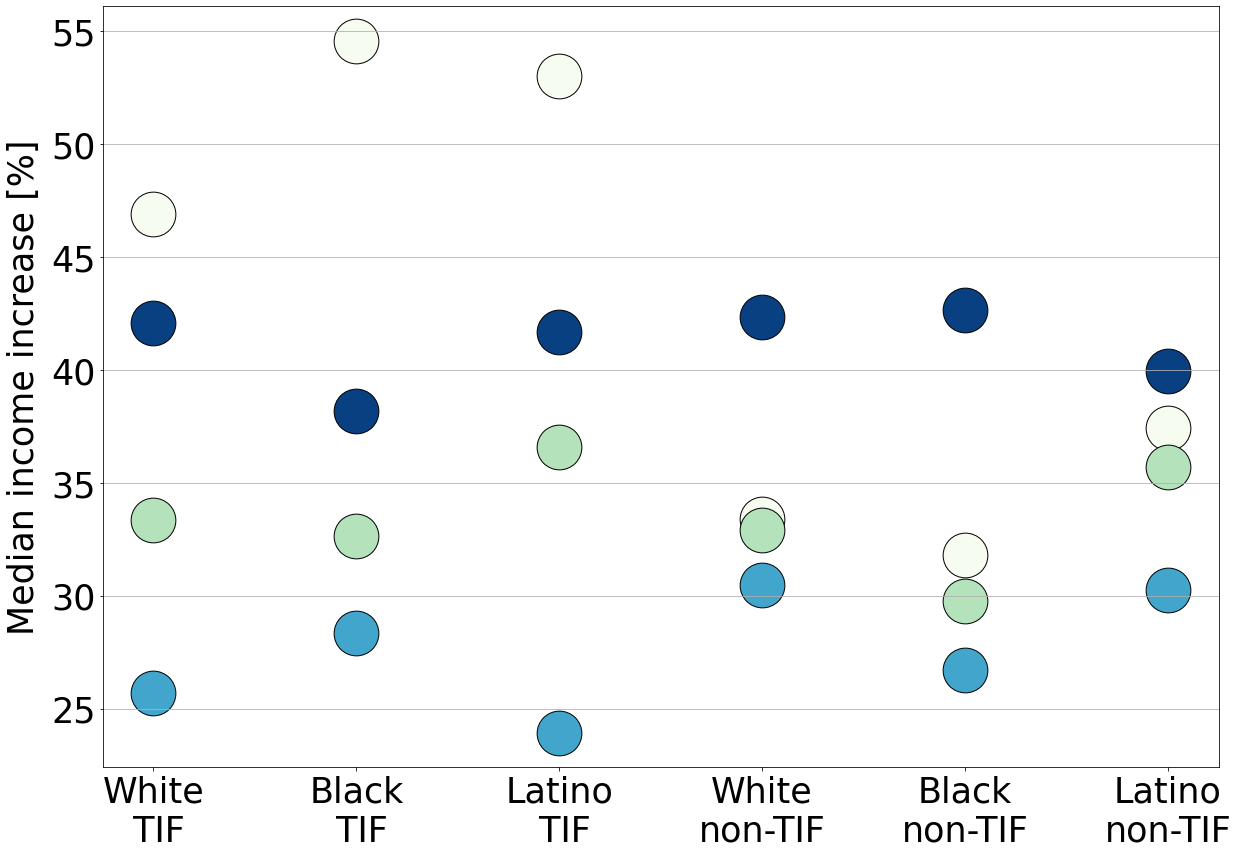

In [140]:
plt.figure(figsize=(20,14))
color_list = cluster_colors
label_name = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']

for cluster_num in range(4):
  plt.scatter([0,1,2],[Median_income_increase_TIF['White'].iloc[cluster_num],Median_income_increase_TIF['Black'].iloc[cluster_num],Median_income_increase_TIF['Latino'].iloc[cluster_num]],color=color_list[cluster_num],label=label_name[cluster_num], s = 2000, edgecolors = 'black')
  plt.scatter([3,4,5],[Median_income_increase_Non_TIF['White'].iloc[cluster_num],Median_income_increase_Non_TIF['Black'].iloc[cluster_num],Median_income_increase_Non_TIF['Latino'].iloc[cluster_num]],color=color_list[cluster_num], s = 2000, edgecolors = 'black')

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Median income increase [%]', fontsize = 35, labelpad=10)
plt.xticks([0,1,2,3,4,5],['White\n TIF','Black\n TIF','Latino\n TIF','White\nnon-TIF', 'Black\nnon-TIF','Latino\nnon-TIF'], fontsize = 35)
plt.yticks(fontsize = 35)
plt.grid(axis = 'y')
plt.show()

In [145]:
Median_income_increase_TIF['White'].iloc[cluster_num], Median_income_increase_TIF['Black'].iloc[cluster_num], Median_income_increase_TIF['Latino'].iloc[cluster_num]

(46.91268112801428, 54.56170189936362, 53.00135011132606)

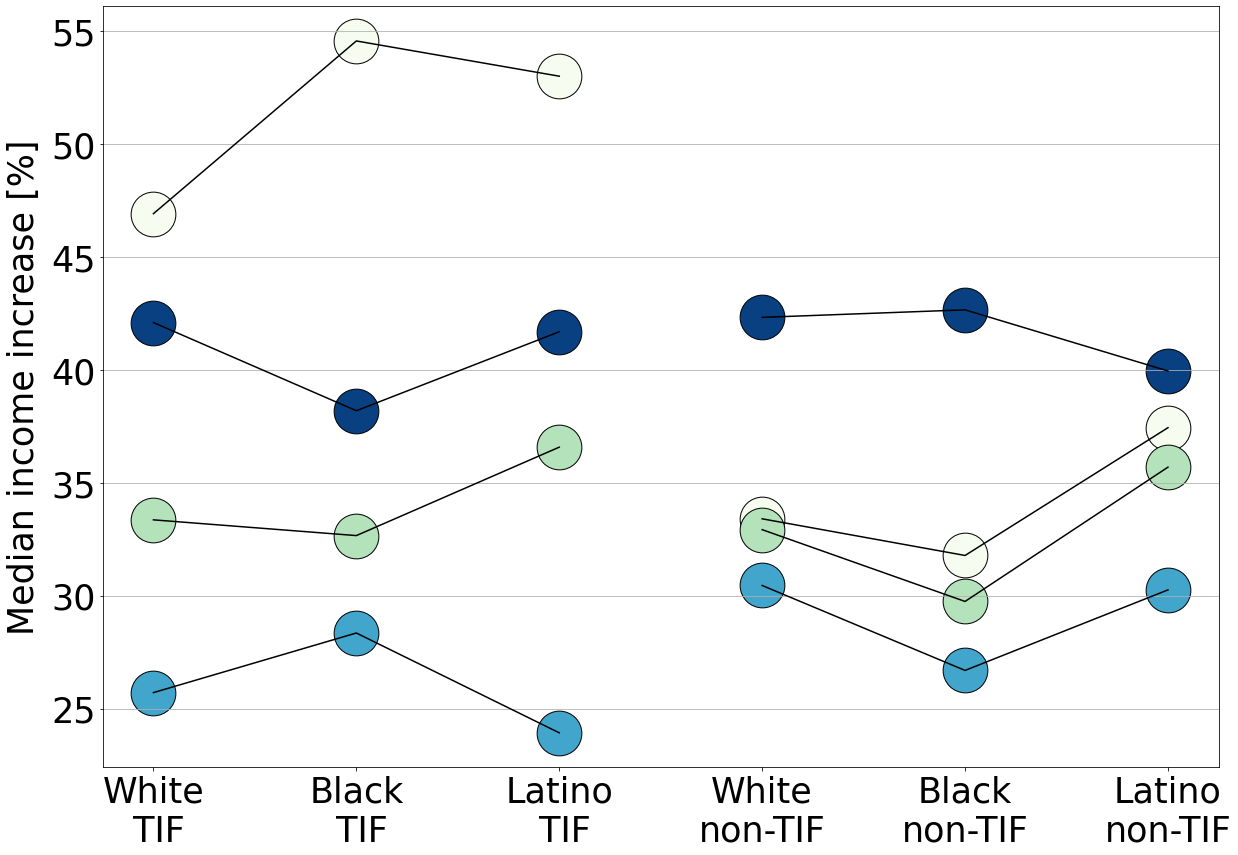

In [160]:
plt.figure(figsize=(20,14))
color_list = cluster_colors
label_name = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']

for cluster_num in range(4):
  plt.scatter([0,1,2],[Median_income_increase_TIF['White'].iloc[cluster_num],Median_income_increase_TIF['Black'].iloc[cluster_num],Median_income_increase_TIF['Latino'].iloc[cluster_num]],color=color_list[cluster_num],label=label_name[cluster_num], s = 2000, edgecolors = 'black')
  plt.plot([0,1,2],[Median_income_increase_TIF['White'].iloc[cluster_num],Median_income_increase_TIF['Black'].iloc[cluster_num],Median_income_increase_TIF['Latino'].iloc[cluster_num]],color='black')

  plt.scatter([3,4,5],[Median_income_increase_Non_TIF['White'].iloc[cluster_num],Median_income_increase_Non_TIF['Black'].iloc[cluster_num],Median_income_increase_Non_TIF['Latino'].iloc[cluster_num]],color=color_list[cluster_num], s = 2000, edgecolors = 'black')
  plt.plot([3,4,5],[Median_income_increase_Non_TIF['White'].iloc[cluster_num],Median_income_increase_Non_TIF['Black'].iloc[cluster_num],Median_income_increase_Non_TIF['Latino'].iloc[cluster_num]],color='black')


# for cluster_num in range(4):
#   TIF_mean = np.mean([Median_income_increase_TIF['White'].iloc[cluster_num], Median_income_increase_TIF['Black'].iloc[cluster_num], Median_income_increase_TIF['Latino'].iloc[cluster_num]])
#   # plt.plot([0,1,2], [TIF_mean]*3, color = color_list[cluster_num], linewidth = 10)
#   # plt.fill_between([0,2], TIF_mean + 0.5, TIF_mean-0.5, color = 'black', alpha = 0.1)

#   non_TIF_mean = np.mean([Median_income_increase_Non_TIF['White'].iloc[cluster_num], Median_income_increase_Non_TIF['Black'].iloc[cluster_num], Median_income_increase_Non_TIF['Latino'].iloc[cluster_num]])
#   plt.plot([3,4,5], [non_TIF_mean]*3, color = color_list[cluster_num], linewidth = 5)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Median income increase [%]', fontsize = 35, labelpad=10)
plt.xticks([0,1,2,3,4,5],['White\n TIF','Black\n TIF','Latino\n TIF','White\nnon-TIF', 'Black\nnon-TIF','Latino\nnon-TIF'], fontsize = 35)
plt.yticks(fontsize = 35)
plt.grid(axis = 'y')
plt.show()